LIBRARIES TO IMPORT

In [2]:
# some libraries to import 
import cv2
import os 
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import plotly.graph_objects as go

CONVERT IMAGE TO BINARY IMAGE (ONLY BLACK AND WHITE)

In [3]:
#code is used for binarize image (image only consist of black and white colors)
def binarize_image(input_image_path):
    color_image = cv2.imread(input_image_path)
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # save binarized image with bi prefix
    cv2.imwrite(f"bi{input_image_path}", binary_image)
    # return the saved image's path
    return f"bi{input_image_path}"

CALCULATE BLACK PIXELS ALONG THE WIDTH AND HEIGHT

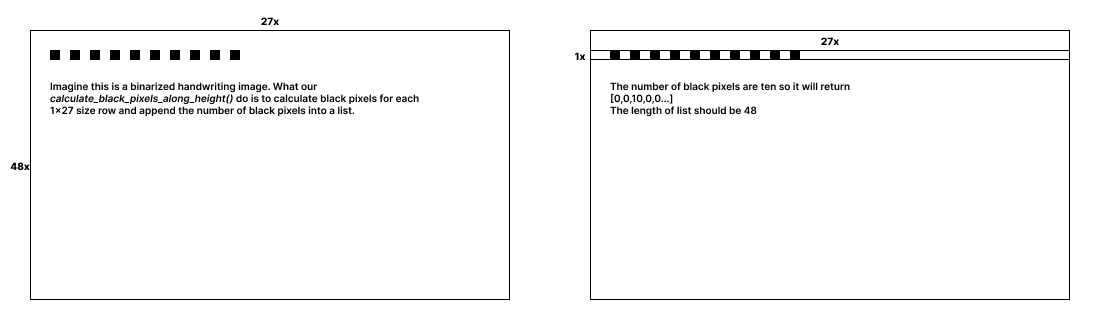

SAME THING ALSO APPLIED TO FOR WIDTH(COLUMNS)

In [4]:
# following functions are used for to calculate the number of black pixels
# calculate_black_pixels_along_height() function calculate pixels horizontally as it is shown in the upper image
def calculate_black_pixels_along_height(input_image_path):
    color_image = cv2.imread(input_image_path)
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY) 
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    black_pixels_along_height = []
    for y in range(binary_image.shape[0]):
        row = binary_image[y:y+1, :]
        black_pixels_count = np.sum(row == 0)
        black_pixels_along_height.append(black_pixels_count)

    return black_pixels_along_height

# do the same thing for the width(columns)
def calculate_black_pixels_along_width(input_image_path):
    color_image = cv2.imread(input_image_path)
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY) 
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    black_pixels_along_width = []
    for x in range(binary_image.shape[1]):
        column = binary_image[:, x:x+1]
        black_pixels_count = np.sum(column == 0)
        black_pixels_along_width.append(black_pixels_count)

    return black_pixels_along_width

FIND THE LENGTH OF EACH ZERO SEQUENCES

In [5]:
# find the lengths of each zero sequences in a list and append its length into a new list. For example :
# [0, 0, 0, 1, 2, 3, 0, 0, 4, 5, 6, 0, 0, 0, 0]
# This function return [3, 2, 4] (the lengths of each zero sequence orderly)

# this function used calculate length of 0 sequences and then we'll find which spacings are between letters and which one between words using 
# find_most_change() function (function after this cell)
def zero_sequence_lengths(lst):
    zero_lengths = []
    count = 0
    for num in lst:
        if num == 0:
            count += 1
        elif count > 0:
            zero_lengths.append(count)
            count = 0
    if count > 0:
        zero_lengths.append(count)
    return zero_lengths

FIND MOST CHANGE

In [6]:
# is used to find, after which number in a list most change happens, for example :
# [2, 5, 11, 19]
# in this case, our function will return 11, beacuse most difference is between 11 and 19
# Between 2 and 5, it is 3. Between 5 and 11, it is 6. Between 11 and 19, it is 8.

# This function is used, when we divide lines into to the words, to select if it is space between letters or space between words.
# It take function's return as limit. If space is smaller than our limit, then it is space between letter and do not divide it.
def find_most_change(points):
    max_change = 0
    change_point = None

    for i in range(len(points) - 1):
        diff = points[i+1] - points[i]
        if diff > max_change:
            max_change = diff
            change_point = (points[i], points[i+1])
    return change_point[0]

CROP THE LINES FROM IMAGE 

In [20]:
# there are drawn lines before we divide it into the parts and this function is used to crop these lines.
# it should be croped because algorithm recognize it as a word 
def crop_line(image_path, margin=2):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    cropped_image = image[margin:height-margin, :]
    filename, _ = os.path.splitext(image_path)
    output_path = f"{filename}.jpg"
    cv2.imwrite(output_path, cropped_image)
    return output_path

# function to crop image that we apply algorithm from top, bottom, left and right until it reaches a black pixel.
def crop_empty_spaces(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    nz = cv2.findNonZero(img)
    if nz is None:
        return
    x, y, w, h = cv2.boundingRect(nz)
    cropped_img = img[y:y+h, x:x+w]
    cv2.imwrite(image_path, cropped_img)
    return image_path

CODE FOR CALCULATION OF SPLITTING POINTS

In [8]:
# it returns the indexes of zero that is in the center of zero sequence. We'll use it as a horizontal dividing point. For example :
# [0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2]
# it will return [1, 10]
# there are two 0 sequences and this returned list are the indexes of the center zeros in each sequence 
def find_horizontal_center_zero(data):
    center_zeros = []
    start_index = None
    for i, num in enumerate(data):
        if num == 0:
            if start_index is None:
                start_index = i
        else:
            if start_index is not None:
                center_index = (start_index + i - 1) // 2
                center_zeros.append(center_index)
                start_index = None
    return center_zeros

# same thing as find_horizontal_center_zero(), but vertical version 
def find_vertical_center_zero(data, limit):
    center_zeros = []
    start_index = None
    for i, num in enumerate(data):
        if num == 0:
            if start_index is None:
                start_index = i
        else:
            if start_index is not None:
                if i - start_index > limit: 
                    center_index = (start_index + i - 1) // 2
                    center_zeros.append(center_index)
                start_index = None
    return center_zeros

DRAW LINES FOR DIVIDING POINTS

In [9]:
# Function draws lines horizontally. How it works ?
# We get where to draw lines using find_horizontal_center_zero() and this function just returns us list that contains arrays for saving cropped images
def draw_horizontal_lines(image_path, line_positions, line_color=(0, 0, 0)):
    img = Image.open(image_path)
    img = img.convert("RGB")    
    draw = ImageDraw.Draw(img)
    for y in line_positions:
        draw.line((0, y, img.width, y), fill=line_color)
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  
    cropped_images = []
    for i in range(len(line_positions)):
        if i == len(line_positions) - 1:
            cropped_img = img_cv2[line_positions[i]:, :]
        else:
            cropped_img = img_cv2[line_positions[i]:line_positions[i + 1], :]
        cropped_images.append(cropped_img)
    return cropped_images

# same thing 
# we get where to draw lines using find_vertical_center_zero() and this function just returns us list that contains arrays for saving cropped images
def draw_vertical_lines(image_path, line_positions, line_color=(0, 0, 0)):
    img = Image.open(image_path)
    img = img.convert("RGB")    
    draw = ImageDraw.Draw(img)
    for x in line_positions:
        draw.line((x, 0, x, img.height), fill=line_color)
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)    
    cropped_images = []
    for i in range(len(line_positions)):
        if i == len(line_positions) - 1:
            cropped_img = img_cv2[:, line_positions[i]:]
        else:
            cropped_img = img_cv2[:, line_positions[i]:line_positions[i + 1]]
        cropped_images.append(cropped_img)
    return cropped_images

ANOTHER METHOD TO FIND PERFECT DIVIDING POINT FOR LINES

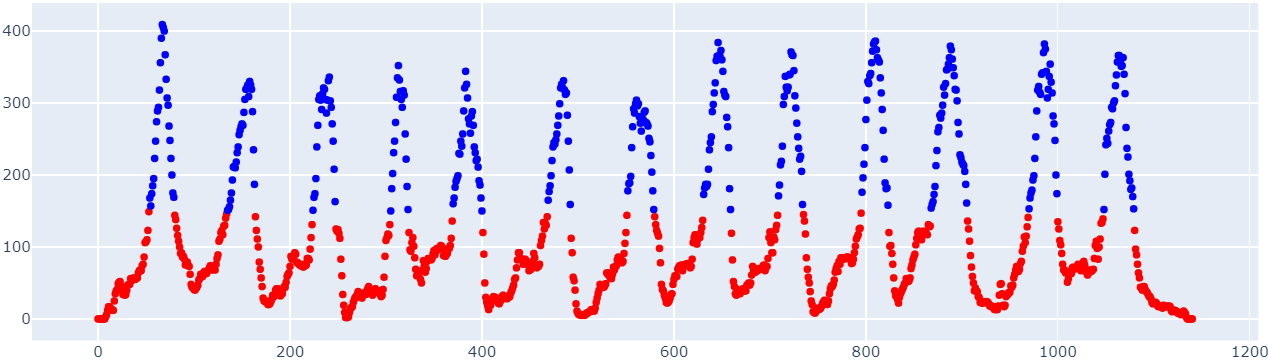
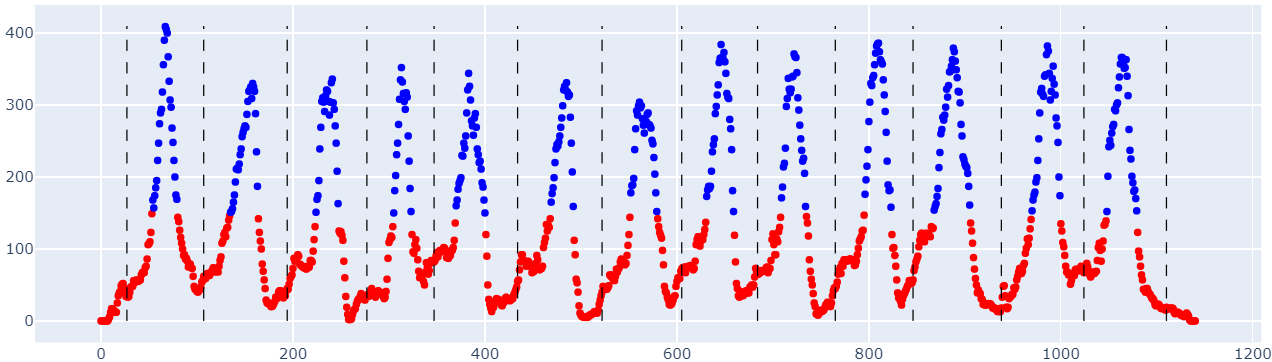

In [18]:
# Our code first divide an image into the lines and then divide lines into the words.
# If the lines are too close to each other, sometimes there is not a space between them and our traditional code does not divide to lines in these cases 
# So, we need a new approach to handle these problem 
# As, you can see in the first picture above, sometimes there is no spacings between lines (red parts show the spacings and it never down to zero)
# Our code search for the zero pixel between lines and in the images like above it will not find this space and will not divide image into lines 
# perfect_dividing_point() function search for the point where the the number of pixels is minimum. It will use this point as a perfect dividing point
# But what if there is minimum points more than one ? As you know dividing point should be unique for each line.
# To prevent it, this function search for the minimum number and if there are two or more minimum number it take the one which is the nearest to the center
# After find the number the minimum number which is the nearest to the center, we find its index in the all data and use it as a dividing point. (2nd image)
 
def perfect_dividing_point(data, image_path):
    # find the sequences where can be spacings between lines
    # I have used 200 for threshold. It means it take the sequences where the number of black pixels are smaller than 200
    def find_sequences(data):
        result = []
        current_sequence = []
        for num in data:
            if num < 200:
                current_sequence.append(num)
            else:
                if current_sequence:
                    if len(current_sequence) > 3:
                        result.append(current_sequence)
                        current_sequence = []
        if current_sequence:
            result.append(current_sequence)
        return result
    
    # find the the index of the number in the sequence which is minimum and nearest the center
    def center_minimum(sequence):
        center_index = int(len(sequence) / 2)
        min_indexes = [i for i, v in enumerate(sequence) if v == min(sequence)]
        return min(min_indexes, key=lambda num: abs(num - center_index))
    
    # I have divided the red parts that you see in the image into separate lists. So if we want to find the index of dividing point at the 
    # whole data, we need to know where is the start point of our sublist in general list.
    def find_sequence_positions(data, sequence):
        for index in range(len(data)):
            founded_sequence = data[index : index + len(sequence)]
            if len(founded_sequence) == len(sequence):
                if founded_sequence == sequence:
                    return index
                
    # contains divided sequences from the whole sequence  
    sequences = find_sequences(data)
    # contains the dividing indexes 
    indexes = []

    for sequence in sequences:
        sequence_positions = find_sequence_positions(data, sequence)
        if sequence_positions is not None:
            index = sequence_positions + center_minimum(sequence)
            indexes.append(index)

    image = Image.open(image_path)
    width, height = image.size

    # when we apply these algorithms, we also apply crop_line() and crop_empty_spaces() algorithms and these functions change the size of image.
    # dividing indexes are not for "the not cropped" images. It shows the dividing points for th cropped images and if we apply it to the
    # original image there will be mismatch in dividing points. So we need to take into account this by finding image's before and after sizes 
    # and learn how many pixels difference are there with cropped and original image to prevent mismatch.
    difference = height - len(data)
    new_indexes = [x + difference for x in indexes]
    return new_indexes 

THE RESULT

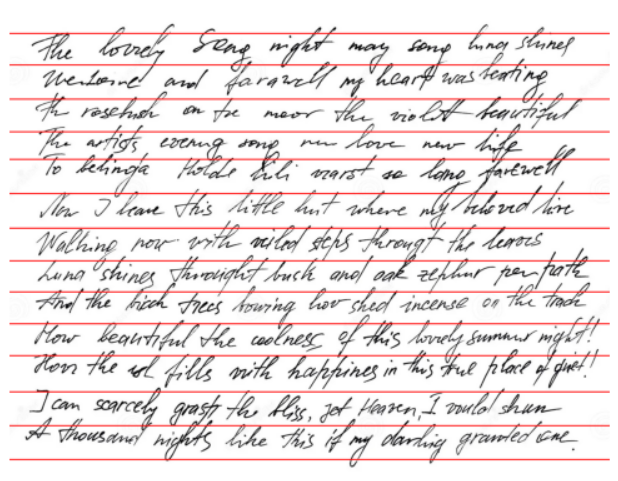

DIVIDE HANDWRITING INTO WORDS

In [38]:
# this part combine all functions and save divided words as separate images.
image_path = "reshadhw.jpg"
horizontal_line_positions = perfect_dividing_point(calculate_black_pixels_along_height(binarize_image(image_path)))
cropped_images = draw_horizontal_lines(image_path, horizontal_line_positions)

index = 0
for i, img in enumerate(cropped_images):
    try:
        cv2.imwrite(f"h{image_path[:-4]}{i}.jpg", img)
        vimage_path = f"h{image_path[:-4]}{i}.jpg"
        space_limit = find_most_change(sorted(list(set(zero_sequence_lengths(calculate_black_pixels_along_width(crop_empty_spaces(crop_line(binarize_image(vimage_path)))))))))    
        vertical_line_positions = find_vertical_center_zero(calculate_black_pixels_along_width(crop_line(binarize_image(vimage_path))), space_limit)
        vcrropped_images = draw_vertical_lines(vimage_path,vertical_line_positions)
        for i, img in enumerate(vcrropped_images):
            cv2.imwrite(f"{index}.jpg", img)
            index = index + 1
    except:
        print("Some error happened")
        continue

Some error happened
Some error happened
Some error happened
Some error happened


In [10]:
# import os

# folder_path = "."
# files = os.listdir(folder_path)

# for file in files:
#     if file.lower().endswith(('.jpg')):
#         if not file[0].isdigit():
#             os.remove(os.path.join(folder_path, file))

In [34]:
import plotly.graph_objects as go


def find_minimum_indexes(lst):
    if not lst:
        return []
    min_value = min(lst)
    min_indexes = [i for i, value in enumerate(lst) if value == min_value]
    center_index = int((len(lst) / 2))
    tuples = []
    for min_index in min_indexes:
        tuples.append((min_index, abs(min_index - center_index)))
        
    min_tuple = min(tuples, key=lambda x: x[1])
    return min_tuple[0]

def check_zero(indexes, values):
    for index in indexes:
        if values[index - 1] == 0:
            return False
    return True

def average_length_of_lists(lst):
    total_length = 0
    num_lists = len(lst)
    
    for sublist in lst:
        total_length += len(sublist)
    
    if num_lists > 0:
        return total_length / num_lists
    else:
        return 0

def identify_red_sequences(data):
    red_sequences = []
    current_sequence = []
    for i, point in enumerate(data):
        if point > 150:
            if current_sequence:
                red_sequences.append(current_sequence)
                current_sequence = []
        else:
            current_sequence.append(i)
    if current_sequence:
        red_sequences.append(current_sequence)
    return red_sequences

data = calculate_black_pixels_along_height(crop_empty_spaces(crop_line(binarize_image("reshadhw.jpg"))))
colors = ['red' if point < 150 else 'blue' for point in data]
red_sequences = identify_red_sequences(data)

fig = go.Figure(data=go.Scatter(y=data, mode='markers', marker=dict(color=colors)))
fig.show()

indexes = []
for red_sequence in red_sequences:
    if len(red_sequence) > 2:
        indexes.append(red_sequence[int(len(red_sequence) / 2)])

data = calculate_black_pixels_along_height(crop_empty_spaces(crop_line(binarize_image("reshadhw.jpg"))))
colors = ['red' if point < 150 else 'blue' for point in data]
fig = go.Figure(data=go.Scatter(y=data, mode='markers', marker=dict(color=colors)))

for index in indexes:
    fig.add_shape(type="line",
                  x0=index, y0=min(data),
                  x1=index, y1=max(data),
                  line=dict(color="black", width=1, dash="dash"))
fig.show()
print(indexes)

[27, 107, 194, 277, 347, 434, 522, 605, 684, 765, 846, 938, 1024, 1110]


In [13]:
# from toolz import pipe
# import plotly.graph_objects as go

# def find_sequences(data):
#     result = []
#     current_sequence = []

#     for num in data:
#         if num < 4:
#             current_sequence.append(num)
#         else:
#             if current_sequence:
#                 if len(current_sequence) > 1:
#                     result.append(current_sequence)
#                     current_sequence = []
    
#     if current_sequence:
#         result.append(current_sequence)
#     print(result)  
#     return result

# def find_minimum_indexes(sequences):
#     slicing_indexes = []
#     for sequence in sequences:
#         min_indexes = [i for i, value in enumerate(sequence) if value == min(sequence)]
#         center_index = int((len(sequence) / 2))
#         tuples = []
#         for min_index in min_indexes:
#             tuples.append((min_index, abs(min_index - center_index)))
            
#         min_tuple = min(tuples, key=lambda x: x[1])
#         slicing_indexes.append(find_sequence_positions(sequences, sequence, min_tuple[0]))
#     print(slicing_indexes)
#     return slicing_indexes

# def find_sequence_positions(sequences, sequence, sequence_index):
#     for i in range(len(sequences)):
#         if sequences[i:i+len(sequence)] == sequence:
#             print("Found")
#             return i + sequence_index

# def visualize_slicings(data, indexes):
#     colors = ['red' if point < 150 else 'blue' for point in data]
#     fig = go.Figure(data=go.Scatter(y=data, mode='markers', marker=dict(color=colors)))
#     for index in indexes:
#         fig.add_shape(type="line",
#                       x0=index, y0=min(data),
#                       x1=index, y1=max(data),
#                       line=dict(color="black", width=1, dash="dash"))
#     fig.show()

# data = calculate_black_pixels_along_width(crop_binarized_image(crop_image(binarize_image("reshadhw.jpg"))))
# slicing_parts = pipe(data, 
#                find_sequences, 
#                find_minimum_indexes,
#                )
# visualize_slicings(data, slicing_parts)

[[3, 3], [3, 3, 3, 3], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 1, 3, 3], [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], [3, 1, 0, 0, 0, 0, 0, 0]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

TRYING SOME THINGS

In [32]:
def perfect_dividing_point(pixels_along_height):
    def find_sequences(data):
        result = []
        current_sequence = []
        for num in data:
            if num < 150:
                current_sequence.append(num)
            else:
                if current_sequence:
                    if len(current_sequence) > 3:
                        result.append(current_sequence)
                        current_sequence = []
        if current_sequence:
            result.append(current_sequence)
        return result

    def center_minimum(sequence):
        center_index = int(len(sequence) / 2)
        min_indexes = [i for i, v in enumerate(sequence) if v == min(sequence)]
        return min(min_indexes, key=lambda num: abs(num - center_index))

    def find_sequence_positions(data, sequence):
        for index in range(len(data)):
            founded_sequence = data[index : index + len(sequence)]
            if len(founded_sequence) == len(sequence):
                if founded_sequence == sequence:
                    return index

    data = calculate_black_pixels_along_width(crop_empty_spaces(crop_line(binarize_image("reshadhw.jpg"))))
    sequences = find_sequences(data)

    indexes = []

    for sequence in sequences:
        sequence_positions = find_sequence_positions(data, sequence)
        if sequence_positions is not None:
            index = sequence_positions + center_minimum(sequence)
            indexes.append(index)
    return indexes 

In [35]:
def visualize_slicings(data, indexes):
    colors = ['red' if point < 150 else 'blue' for point in data]
    fig = go.Figure(data=go.Scatter(y=data, mode='markers', marker=dict(color=colors)))
    for index in indexes:
        fig.add_shape(type="line",
                      x0=index, y0=min(data),
                      x1=index, y1=max(data),
                      line=dict(color="black", width=1, dash="longdashdot"))
    fig.show()

data = calculate_black_pixels_along_height(crop_empty_spaces(crop_line(binarize_image("reshadhw.jpg"))))
visualize_slicings(data, indexes)
print(indexes)
print(len(data))

[27, 107, 194, 277, 347, 434, 522, 605, 684, 765, 846, 938, 1024, 1110]
1141


34


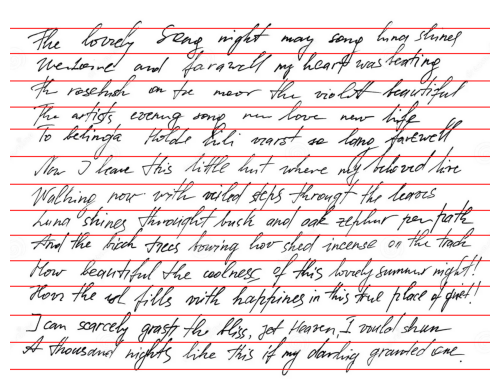

In [36]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image = Image.open("reshadhw.jpg")
width, height = image.size

difference = height - len(data)
print(difference)
new_indexes = [x + difference for x in indexes]

draw = ImageDraw.Draw(image)
line_color = (255, 0, 0)

for index in new_indexes:
    start_point = (0, index)
    end_point = (width, index)
    draw.line([start_point, end_point], fill=line_color, width=3)

plt.imshow(image)
plt.axis('off')
plt.show()

In [1]:
import random
import string

class PasswordGenerator:
    def __init__(self):
        self.num_passwords = 0
        self.password_length = 0
        self.include_numbers = False
        self.include_uppercase = False
        self.include_lowercase = False
        self.include_symbols = False

    def get_user_input(self):
        self.num_passwords = int(input("How many passwords do you need? "))
        self.password_length = int(input("Length of one password? "))
        self.include_numbers = input("Include numbers? (yes/no) ").lower() == "yes"
        self.include_uppercase = input("Include uppercase letters? (yes/no) ").lower() == "yes"
        self.include_lowercase = input("Include lowercase letters? (yes/no) ").lower() == "yes"
        self.include_symbols = input("Include symbols? (yes/no) ").lower() == "yes"

    def generate_password(self):
        characters = ""
        if self.include_numbers:
            characters += string.digits
        if self.include_uppercase:
            characters += string.ascii_uppercase
        if self.include_lowercase:
            characters += string.ascii_lowercase
        if self.include_symbols:
            characters += "!#$%&*+-=?@^_"
        return ''.join(random.choice(characters) for _ in range(self.password_length))

    def generate_passwords(self):
        passwords = []
        for _ in range(self.num_passwords):
            passwords.append(self.generate_password())
        return passwords

if __name__ == "__main__":
    generator = PasswordGenerator()
    generator.get_user_input()
    generated_passwords = generator.generate_passwords()
    print("Generated Passwords:")
    for password in generated_passwords:
        print(password)

ValueError: invalid literal for int() with base 10: ''